In [1]:
import sncosmo
import numpy as np
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from sncosmo.salt2utils import BicubicInterpolator
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)
import pickle as pk
from matplotlib.backends.backend_pdf import PdfPages
import os 
from matplotlib.offsetbox import AnchoredText
import astropy.constants as const
import astropy.units as u
import seaborn as sns

sns.set(style='whitegrid')
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

H_ERG_S = const.h.cgs.value
C_AA_PER_S = const.c.to(u.AA / u.s).value
HC_ERG_AA = H_ERG_S * C_AA_PER_S
SCALE_FACTOR = 1e-12

## Comentários

Estou testando cortar partes dos filtros pros modelos falharem menos.

Algumas SNe estão repetidas. Não há ajuste duplicado porque há uma ordem para checar se existem os arquivos, então o último a ser checado é o ajustado. Mas isso é um problema a ser observado.

A covariância afeta bastante o resultado do CHISQ inclusive para o SALT2 e SALT2 cortado, então acho que podemos ser flexíveis nesse corte ou melhorar o modelo da covariância do EXP.

## Recuperando curvas de luz

In [2]:
path="/home/cassia/SNANA/snroot/lcmerge/SDSS_allCandidates+BOSS/"

In [3]:
sne_sdss_pan=pd.read_csv("sdss_pantheon.txt",header=None,dtype=str)

In [4]:
sne_list=np.array(sne_sdss_pan).T[0]

In [5]:
path_filters="/home/cassia/SNANA/snroot/filters/PS1/Pantheon/SDSS_Doi2010/CCDAVG/"

In [6]:
len(sne_list)

337

## Registrando filtros e criando sistema de magnitude composto

In [7]:
ab = sncosmo.get_magsystem('ab')

In [8]:
for filt in ["U","G","R","I","Z"]:
    wave = pd.read_csv(path_filters+filt+".dat",header=None,sep="\s+",comment="#")[0].values
    trans = pd.read_csv(path_filters+filt+".dat",header=None,sep="\s+",comment="#")[1].values
    band = sncosmo.Bandpass(wave, trans, name='SDSS_'+filt,trim_level=0.05)
        
    sncosmo.registry.register(band)

In [9]:
magsystem = {"SDSS_U":('ab',0.00000),
             "SDSS_G":('ab',-0.0073-0.0029473880),
             "SDSS_R":('ab',-0.0088+0.0044133478),
             "SDSS_I":('ab',-0.0090+0.00072395845),
             "SDSS_Z":('ab',-0.0094-0.0083579659)}

In [10]:
magsys = sncosmo.CompositeMagSystem(bands=magsystem,name="magsys")

In [11]:
# f=10**(-0.4m+0.4Z)

In [12]:
# m=-2.5*log10(flux)+Z

In [13]:
# FCAL=10**(-0.4m+11)

## Ajustando curvas de luz

In [14]:
def lc_fit(sn):    
    try:
        dat = sncosmo.read_snana_fits(path+"SDSS_allCandidates+BOSS_HEAD.FITS",path+"SDSS_allCandidates+BOSS_PHOT.FITS",snids=[str(sn).encode('UTF-8')])[0]
    except:
        print(f"File not found for SN {sn}")
        return None
        
    meta = dat.meta
    
    surv="SDSS"

    dat.add_column([surv+"_"+f.upper() for f in dat["FLT"]], name='FILTER') # decodificando
    dat.remove_column("FLT")
      
    dat.remove_rows(np.where(dat["FLUXCAL"]<0)[0])
    dat.remove_rows(np.where(np.isnan(dat["MAG"]))[0])

    magsys=sncosmo.CompositeMagSystem(bands=magsystem,name="magsys")
    sncosmo.register(magsys,force=True)

    dat["FLUX"]=[magsys.band_mag_to_flux(dat["MAG"][i],dat["FILTER"][i]) for i in range(len(dat["MAG"]))]
    dat["FLUXERR"]=[abs(0.4*dat["FLUX"][i]*np.log(10.)*dat["MAGERR"][i]) for i in range(len(dat["MAG"]))]
    dat.remove_columns(["FIELD","TELESCOPE","PHOTFLAG","PHOTPROB","MAG","MAGERR","ZEROPT","ZEROPT_ERR"])

    dat.remove_rows(np.where(dat["FLUX"]/dat["FLUXERR"]<5)[0])
                             
    # ref de repouso: (t-t0)/(1+z), no SNANA fazem um corte de -15 a 45 no referencial de repouso. E também tem um corte no 
    # intervalo de comprimento de onda, eu apliquei esses cortes abaixo em phase_range e wave_range. Porém não tenho certeza
    # se o sncosmo corta no ref de repouso ou do observador. Alterando isso, os valores de x1 para 2001ah e 2001az mudam drasticamento
    # equivalendo a mesma mudança que ocorre no snana quando fazemos a mesma alteração no TREST_REJECT.    
  
    dat["ZP"]=[2.5*np.log10(magsys.zpbandflux(f)) for f in dat["FILTER"]]
    dat.add_column("magsys", name='ZPSYS')
    
    dust = sncosmo.F99Dust() 

    # para algumas sne como 2006bb o chi2 da minimizacao da Nan e não é possível ajustar a sn. A mesma sn no snana é ajustada pelo salt.
    # alterando intervalo de dias e comprimento de onda de atuação do ajustador, ainda não é possível evitar o nan já no primeiro passo.
    
    model = sncosmo.Model(source='salt2',effects=[dust],effect_names=['mw'],effect_frames=['obs'])
    model.set(mwebv=meta["MWEBV"],z=meta["REDSHIFT_FINAL"]) 

    try:
        result, fitted_model = sncosmo.fit_lc(dat, model, ['t0', 'x0', 'x1', 'c'],modelcov=True, bounds={"t0":(meta["PEAKMJD"]-5,meta["PEAKMJD"]+5)}, phase_range=(-15, 45.), wave_range=(3000.,7000.), verbose=False)
    except:
        print(f"SN {sn} fit returns NaN")
        result=None
        fitted_model=None
    
    return meta, surv, dat, result, fitted_model

In [15]:
pp = PdfPages("./lc_fit_plot_SALT2_SDSS_Pantheon.pdf")

In [16]:
def lc_fit_plot(sn, surv,table_data, result, fitted_model):
    z=round(result["parameters"][0],2)
    t0=round(result["parameters"][1],2)
    x1=round(result["parameters"][3],2)
    x1err=round(result["errors"]["x1"],2)
    c=round(result["parameters"][4],2)
    cerr=round(result["errors"]["c"],2)
    mwebv=result["parameters"][5]
    phase=np.linspace(t0-10.,t0+40.,100)
    table_data.remove_rows(np.where(table_data["MJD"]<t0-10.))
    table_data.remove_rows(np.where(table_data["MJD"]>t0+40.))
    fig=plt.figure(figsize=(12,8))
    for i,f in enumerate(magsystem.keys()): 
        if len(table_data[table_data["FILTER"]==f])==0:
            pass
        else:
            try:
                plt.plot(phase-t0,fitted_model.bandflux(f, phase)*10**(-0.4*table_data[table_data["FILTER"]==f]["ZP"][0]+11),linewidth=3,color='C%i'%i)
                plt.errorbar(table_data[table_data["FILTER"]==f]["MJD"]-t0,table_data[table_data["FILTER"]==f]["FLUXCAL"],yerr=table_data[table_data["FILTER"]==f]["FLUXCALERR"],label=f,ls="none", marker='o',markersize=8,color='C%i'%i)
                plt.xlabel(f"MJD-{t0}",fontsize=15)
                plt.ylabel(r"FLUX ($Z_{AB}$=27.5)",fontsize=15)
                plt.title(f"SALT2 fit, SN: {sn}({surv}),   z:{z:.2f},   x1={x1:.2f}$\pm${x1err:.2f},   c={c:.2f}$\pm${cerr:.2f},   mwebv={mwebv:.2f}",fontsize=15)
                plt.xlim(-12,42)
                plt.legend(fontsize=15)
            except:
                print(f"Filter {f} of sn {sn} not defined.")
                continue
    pp.savefig()
    plt.close(fig)
    #plt.show()

In [17]:
 def return_fit_data(sn,meta,res,model_name):
    return [sn, "SDSS", meta["REDSHIFT_FINAL"], 0., res.parameters[1],
           res.errors["t0"], res.parameters[2], res.errors["x0"], res.parameters[3],
           res.errors["x1"], res.parameters[4], res.errors["c"],
           res.covariance[1][2], res.covariance[1][3], res.covariance[2][3], 
           res.chisq/res.ndof, model_name]

In [18]:
all_fit_data=[]
f=open("./lc_failed_fits_SALT2_SDSS_Pantheon.txt","w")
i=0
for j,sn in enumerate(sne_list):
    print(sn, f"({j}/{len(sne_list)})")

    if lc_fit(sn)== None:
        f.write(f"File not found for SN {sn}")
        continue
        
    meta, surv, table_data, result, fitted_model=lc_fit(sn) 
    
    if result is None:
        f.write(f"SN {sn} fit returns NaN\n")
        continue
    else:
        if result.success and result.ndof>0:
            all_fit_data.append(return_fit_data(sn,meta,result,"SALT2_ORI"))
        elif result.success and result.ndof==0:
            f.write("ndof 0 for SN"+sn+"\n")
        elif not result.success:
            f.write("Unsuccessful fit of SN"+sn+"\n")

    lc_fit_plot(sn, surv, table_data, result, fitted_model)                       

744 (0/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1112 (1/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1241 (2/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 1241 not defined.
1371 (3/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 1371 not defined.
1580 (4/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1794 (5/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2031 (6/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2102 (7/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 2102 not defined.
2165 (8/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2422 (9/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2635 (10/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2689 (11/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2916 (12/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2992 (13/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3080 (14/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3087 (15/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3317 (16/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3377 (17/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3451 (18/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


4046 (19/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


4241 (20/337)
4679 (21/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5103 (22/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5533 (23/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5549 (24/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 5549 not defined.
5635 (25/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5957 (26/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5994 (27/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6057 (28/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 6057 not defined.
6108 (29/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6196 (30/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6315 (31/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6422 (32/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6558 (33/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 6558 not defined.
6924 (34/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7147 (35/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 7147 not defined.
7243 (36/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7779 (37/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7847 (38/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


8495 (39/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


8921 (40/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


9032 (41/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


9457 (42/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


9467 (43/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12779 (44/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 12779 not defined.
12781 (45/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 12781 not defined.
12856 (46/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12881 (47/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12883 (48/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12898 (49/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 12898 not defined.
12927 (50/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12950 (51/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 12950 not defined.
12972 (52/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13005 (53/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13038 (54/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 13038 not defined.
13044 (55/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13136 (56/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13152 (57/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13254 (58/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13411 (59/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13578 (60/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13610 (61/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13689 (62/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13736 (63/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13796 (64/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14019 (65/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14024 (66/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14108 (67/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14331 (68/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14397 (69/337)
14421 (70/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14451 (71/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14735 (72/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14871 (73/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 14871 not defined.
14979 (74/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15057 (75/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15129 (76/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15161 (77/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15213 (78/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15219 (79/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15234 (80/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15259 (81/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15287 (82/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15301 (83/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15354 (84/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15383 (85/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15421 (86/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15440 (87/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15443 (88/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15456 (89/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15461 (90/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15467 (91/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15583 (92/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15776 (93/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15868 (94/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15901 (95/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16021 (96/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16032 (97/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16073 (98/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16093 (99/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16099 (100/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16106 (101/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16116 (102/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16165 (103/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16206 (104/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16211 (105/337)
16213 (106/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16281 (107/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17168 (108/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17215 (109/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17218 (110/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17220 (111/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17240 (112/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 17240 not defined.
17366 (113/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17389 (114/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17464 (115/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17497 (116/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17552 (117/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17784 (118/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 17784 not defined.
17791 (119/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17809 (120/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17811 (121/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17825 (122/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17875 (123/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17884 (124/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18030 (125/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18241 (126/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 18241 not defined.
18323 (127/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18325 (128/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18466 (129/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18486 (130/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18602 (131/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18617 (132/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18697 (133/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 18697 not defined.
18721 (134/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18749 (135/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18804 (136/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18809 (137/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18835 (138/337)
SN 18835 fit returns NaN


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/models.py:813: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/models.py:813: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/cassia/anaconda3/e

SN 18835 fit returns NaN
18855 (139/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18927 (140/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18940 (141/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18945 (142/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18965 (143/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19002 (144/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19023 (145/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19027 (146/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19067 (147/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19128 (148/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19230 (149/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19282 (150/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19341 (151/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19353 (152/337)
SN 19353 fit returns NaN
SN 19353 fit returns NaN
19425 (153/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/models.py:813: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/models.py:813: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/cassia/anaconda3/e

19596 (154/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19632 (155/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19775 (156/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19794 (157/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19818 (158/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19913 (159/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19953 (160/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19969 (161/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19990 (162/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20039 (163/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20084 (164/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20088 (165/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20111 (166/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20142 (167/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20227 (168/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20245 (169/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20364 (170/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20581 (171/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20687 (172/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


21006 (173/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


21033 (174/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


21042 (175/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


21062 (176/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


21502 (177/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 21502 not defined.
722 (178/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 722 not defined.
762 (179/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


774 (180/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 774 not defined.
1032 (181/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


1253 (182/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2017 (183/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2246 (184/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2308 (185/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2330 (186/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2372 (187/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2440 (188/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2533 (189/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2561 (190/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 2561 not defined.
2789 (191/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2943 (192/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3199 (193/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3452 (194/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


3592 (195/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 3592 not defined.
4000 (196/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


4577 (197/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5391 (198/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5395 (199/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 5395 not defined.
5550 (200/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5717 (201/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5736 (202/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5751 (203/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


5844 (204/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6137 (205/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6192 (206/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6249 (207/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6304 (208/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6406 (209/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6649 (210/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6699 (211/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6780 (212/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6933 (213/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


6936 (214/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7143 (215/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7473 (216/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7475 (217/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7512 (218/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


7876 (219/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 7876 not defined.
8046 (220/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


8213 (221/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


8719 (222/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 8719 not defined.
10028 (223/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 10028 not defined.
10434 (224/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 10434 not defined.
10805 (225/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 10805 not defined.
12843 (226/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12853 (227/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12855 (228/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12860 (229/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 12860 not defined.
12928 (230/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12971 (231/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


12977 (232/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13025 (233/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13045 (234/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13070 (235/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13072 (236/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13099 (237/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13135 (238/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 13135 not defined.
13305 (239/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13354 (240/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13506 (241/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13511 (242/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13641 (243/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13655 (244/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13727 (245/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13757 (246/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13830 (247/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13835 (248/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


13894 (249/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 13894 not defined.
13934 (250/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14157 (251/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14212 (252/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14261 (253/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14284 (254/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14298 (255/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14437 (256/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14456 (257/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14481 (258/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14846 (259/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


14984 (260/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15132 (261/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15171 (262/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15201 (263/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15203 (264/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15222 (265/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15229 (266/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15356 (267/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15365 (268/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15425 (269/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15433 (270/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15453 (271/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15466 (272/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15508 (273/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15584 (274/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15648 (275/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15674 (276/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15704 (277/337)
15872 (278/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


15897 (279/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16069 (280/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16072 (281/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16100 (282/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16185 (283/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 16185 not defined.
16232 (284/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16259 (285/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 16259 not defined.
16276 (286/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


16350 (287/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17171 (288/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17186 (289/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 17186 not defined.
17208 (290/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17223 (291/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17253 (292/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17258 (293/337)
SN 17258 fit returns NaN
SN 17258 fit returns NaN
17280 (294/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/models.py:813: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/models.py:812: RuntimeWarning: invalid value encountered in multiply
  return (self._parameters[0] * (m0 + self._parameters[1] * m1) *
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, d

17332 (295/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17340 (296/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17435 (297/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17605 (298/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17629 (299/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


17801 (300/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18091 (301/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18415 (302/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18463 (303/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18485 (304/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18604 (305/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18612 (306/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 18612 not defined.
18650 (307/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 18650 not defined.
18740 (308/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18768 (309/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18787 (310/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


18807 (311/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19008 (312/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19101 (313/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19174 (314/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19207 (315/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19543 (316/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 19543 not defined.
19616 (317/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19658 (318/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19702 (319/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19757 (320/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19940 (321/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


19968 (322/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 19968 not defined.
19992 (323/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20040 (324/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20048 (325/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20064 (326/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 20064 not defined.
20106 (327/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20144 (328/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20345 (329/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20430 (330/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


20625 (331/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 20625 not defined.
20764 (332/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


21034 (333/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: SDSS_Z(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Filter SDSS_Z of sn 21034 not defined.
22075 (334/337)


/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(
/home/cassia/anaconda3/envs/sne/lib/python3.10/site-packages/iminuit/util.py:143: UserWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


2008050 (335/337)
File not found for SN 2008050
2008051 (336/337)
File not found for SN 2008051


In [19]:
pp.close()

In [20]:
f.close()

## Salvando dados dos ajustes

In [21]:
df=pd.DataFrame(all_fit_data)

In [22]:
df=pd.DataFrame(all_fit_data)
df.columns=("SNNAME", "SURVEY", "Z", "ZERR", "T0", "T0ERR", "X0", "X0ERR", "X1", "X1ERR", "X2/C", "X2/CERR", "COV_X0_X1", "COV_X0_X2/C", "COV_X1_X2/C", "CHISQ/NDOF", "MODEL")

In [23]:
df["mB"]=-2.5*np.log10(df["X0"])+10.635  # Mosher 2014
df["mBERR"]=np.abs(-2.5*np.log10(np.e)/df["X0"]*df["X0ERR"])
df["COV_mB_X1"]=-2.5*np.log10(np.e)/df["X0"]*df["COV_X0_X1"]
df["COV_mB_X2/C"]=-2.5*np.log10(np.e)/df["X0"]*df["COV_X0_X2/C"]

In [24]:
df.to_csv("./lc_fit_results_SALT2_SDSS_Pantheon.txt", sep=' ', index=False)

## Análises dos Ajustes

In [25]:
df_salt2_bf_cuts=df[df["MODEL"]=="SALT2_ORI"].reset_index(drop=True)
df_salt2=df[(df["MODEL"]=="SALT2_ORI") & (abs(df["X1"])<=3.) & (abs(df["X2/C"])<=0.3) & (df["CHISQ/NDOF"]<=5.)].reset_index(drop=True)

In [26]:
passcut_salt2=len(df[df["MODEL"]=="SALT2_ORI"])
passcut_salt2_x1=len(df[(df["MODEL"]=="SALT2_ORI") & (abs(df["X1"])<=3.)])
passcut_salt2_c=len(df[(df["MODEL"]=="SALT2_ORI") & (abs(df["X2/C"])<=0.3)])
passcut_salt2_chi2=len(df[(df["MODEL"]=="SALT2_ORI") & (df["CHISQ/NDOF"]<=5.)])

#### Checando distribuição dos parâmetros

De um total 172 SNe, 331 foram bem ajustadas.
13 não passaram no corte de |X1| < 3.
0 não passaram no corte de |C| < 0.3
6 não passaram no corte de Chi2 < 5.
No final ficamos com 313 Sne.


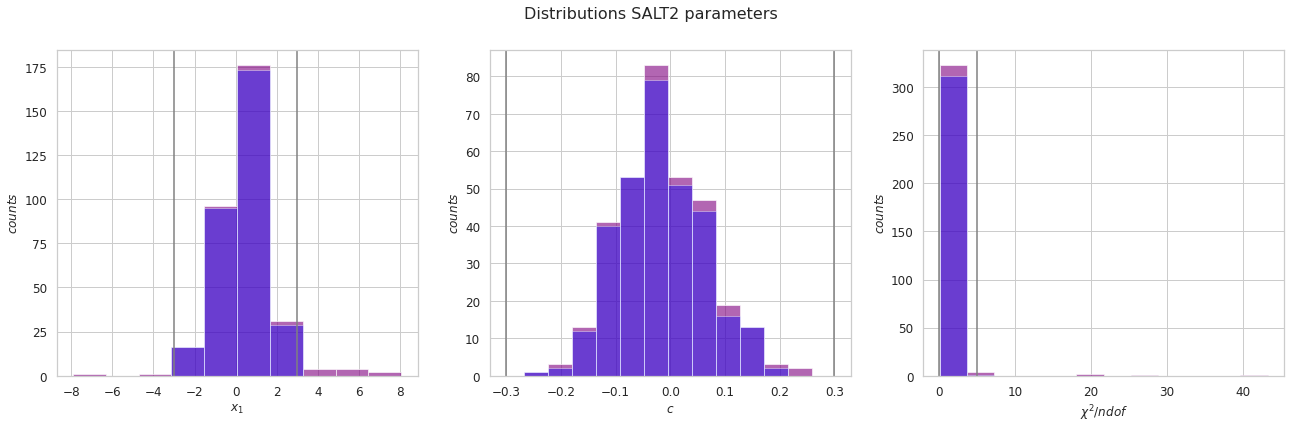

In [27]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(22,6))
fig.suptitle("Distributions SALT2 parameters",fontsize=16)

bins = 10
bins = np.histogram(np.hstack((df_salt2_bf_cuts["X1"], df_salt2["X1"])), bins=bins)[1]
ax1.hist(df_salt2_bf_cuts["X1"],color="purple",bins=bins,alpha=0.6)
ax1.hist(df_salt2["X1"],color="blue",bins=bins,alpha=0.4)
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$counts$")
ax1.axvline(3.,c="gray")
ax1.axvline(-3.,c="gray")

bins = 12
bins = np.histogram(np.hstack((df_salt2_bf_cuts["X2/C"], df_salt2["X2/C"])), bins=bins)[1]
ax2.hist(df_salt2_bf_cuts["X2/C"],bins=bins,color="purple",alpha=0.6)
ax2.hist(df_salt2["X2/C"],color="blue",alpha=0.4,bins=bins)
ax2.set_xlabel(r"$c$")
ax2.set_ylabel(r"$counts$")
ax2.axvline(0.3,c="gray")
ax2.axvline(-0.3,c="gray")

bins = 12
bins = np.histogram(np.hstack((df_salt2_bf_cuts["CHISQ/NDOF"], df_salt2["CHISQ/NDOF"])), bins=bins)[1]
ax3.hist(df_salt2_bf_cuts["CHISQ/NDOF"],bins=bins,color="purple",alpha=0.6)
ax3.hist(df_salt2["CHISQ/NDOF"],bins=bins,color="blue",alpha=0.4)
ax3.set_xlabel(r"$\chi^2/ndof$")
ax3.set_ylabel(r"$counts$")
ax3.axvline(0.,c="gray")
ax3.axvline(5.,c="gray")

print(f"De um total 172 SNe, {passcut_salt2} foram bem ajustadas.")
print(f"{passcut_salt2-passcut_salt2_x1} não passaram no corte de |X1| < 3.")
print(f"{passcut_salt2-passcut_salt2_c} não passaram no corte de |C| < 0.3")
print(f"{passcut_salt2-passcut_salt2_chi2} não passaram no corte de Chi2 < 5.")
print(f"No final ficamos com {len(df_salt2)} Sne.")

#### Checando correlação entre os parâmetros

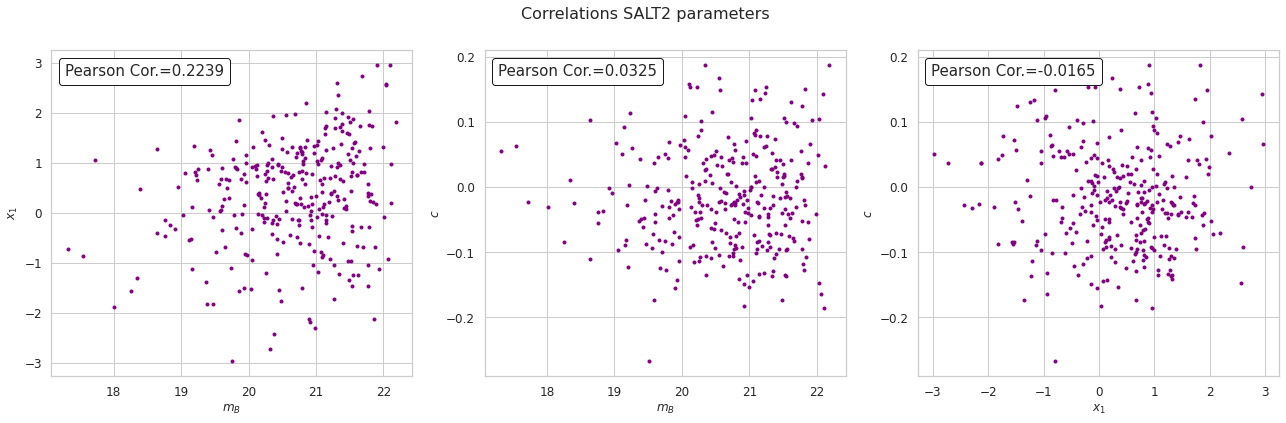

In [28]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1,3,figsize=(22,6))
fig.suptitle("Correlations SALT2 parameters",fontsize=16)

ax1.plot(df_salt2["mB"],df_salt2["X1"],'.',c="purple")
ax1.set_xlabel(r"$m_B$")
ax1.set_ylabel(r"$x_1$")
at1 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["mB"], df_salt2["X1"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at1)

ax2.plot(df_salt2["mB"],df_salt2["X2/C"],'.',c="purple")
ax2.set_xlabel(r"$m_B$")
ax2.set_ylabel(r"$c$")
at2 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["mB"], df_salt2["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at2.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax2.add_artist(at2)

ax3.plot(df_salt2["X1"],df_salt2["X2/C"],'.',c="purple")
ax3.set_xlabel(r"$x_1$")
ax3.set_ylabel(r"$c$")
at3 = AnchoredText("Pearson Cor.=%.4f"%(round(np.corrcoef(df_salt2["X1"], df_salt2["X2/C"])[0][1],4)), prop=dict(size=15), frameon=True, loc='upper left')
at3.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax3.add_artist(at3);